# Import

In [1]:
RICA_HOME = "/home/spoudel/GRA/rica"
# RICA_HOME = '/home/garrettw/codebase/rica'

In [2]:
import os
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import signal
from scipy.stats import zscore
import sys

sys.path.append(RICA_HOME)

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples

from rica.domain.vibration import vibration
from rica.domain.configure import configure
from rica.use_cases.filter import create_filter_bank, filter_signal
from rica.use_cases.power import (compute_min_max_power, compute_power,
                                  create_power_object)
from rica.domain.density import ExtendedKMeans

# Helper Functions

In [3]:
def _plot_silhouette(X, cluster_labels, ax):
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    n_clusters = max(cluster_labels) + 1

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

def train(training_data, k=6):
    print(training_data.head())
    x = training_data.iloc[:, 2:].values

    # Define model
    model = ExtendedKMeans(n_clusters=k)

    # Train model
    model.fit(x)

    # Sort Cluster Centers
    model.sort_clusters()

    # Return trained model
    return model

def load_vibration_data(filename):
    """Read and format a csv file of vibration data"""
    df = pd.read_csv(filename, header=0)
    df.time = pd.to_datetime(df.time)
    vib_list = convert_to_vibration(df)
    return vib_list, df

def convert_to_vibration(df):
    """Compute vibration objects from dataframe"""
    vibration_list = []
    for i in range(127, 128*(len(df)//128), 127):
        vibration_list.append(
            vibration(
                timestamp=df.loc[i, "time"],
                data=df.loc[i - 127 : i, "vibration"].values,
            )
        )
    return vibration_list

def estimate_fundFreq(df):

    f, _, Sxx = signal.spectrogram(
        df.vibration.values,
        1000,
        "boxcar",
        nperseg=256,
        noverlap=128,
        scaling="density",
        mode="magnitude",
    )

    S_mean = np.mean(Sxx, axis=1)
    fundFreq = f[np.argmax(S_mean)]
    return fundFreq

def compute_all_power(filter_object, power_object, vibration_data):
    # pass vibration data through the power calculator
    filtered_list = [
        filter_signal(filter_object, vibration) for vibration in vibration_data
    ]
    filtered_output_list = [filtered_list[i-1] + filtered_list[i] for i in range(1, len(filtered_list))]
    power_list = [
        compute_power(power_object, filterOutput) for filterOutput in filtered_output_list
    ]
    return power_list

def power_to_df(power_list):
    df = pd.DataFrame([])
    for p in power_list:
        df = df.append(p.to_dict(), ignore_index=True)
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

# Data Loading

In [4]:
RICA_HOME = Path(RICA_HOME)
CONFIG_PATH = Path("/home/spoudel/All_Thesis/Thesis_program/Data/shawnee/location_1/")
# PROJECT_PATH = Path(RICA_HOME/'projects/shawnee')
vibration_path = PROJECT_PATH/ 'calibration-data.csv'

NameError: name 'PROJECT_PATH' is not defined

### Vibrations

In [5]:
vib_list, df = load_vibration_data(vibration_path)

print("Vibrations")
print(f"\tN: {len(vib_list)}")
print(f"\tStart: {vib_list[0].timestamp}")
print(f"\tEnd: {vib_list[-1].timestamp}")

Vibrations
	N: 17080
	Start: 2022-12-05 08:00:00.127000+00:00
	End: 2022-12-05 08:36:09.160000+00:00


In [6]:
print(len(vib_list[-1].data))

128


### Fundamental Frequency

In [7]:
fund = estimate_fundFreq(df)
print("Fundamental Frequency")
print(f"\tEstimated: {fund:0.2f}")

Fundamental Frequency
	Estimated: 35.16


### Compute Power

In [8]:
# params = configure(PROJECT_PATH / 'calib.yml')
params = configure(CONFIG_PATH / 'default_config_file.yml')
params.fundFreq = fund
params.mean = [0, 0, 0, 0, 0, 0, 0]
params.std = [1, 1, 1, 1, 1, 1, 1]

# Create filter & Power objects
oFilter = create_filter_bank(params.to_dict().copy())
(oPower, _) = create_power_object(params.to_dict().copy())

# Get Raw Power
power_list = compute_all_power(oFilter, oPower, vib_list)
power_df = power_to_df(power_list)

# Scale total Power
myMax = power_df['total_power'].quantile(0.95)     #### Are we still doing this here to get 
# myMax = power_df['total_power'].max()
myMin = power_df['total_power'].min()
power_df['total_power'] = 100 * (power_df['total_power'] - myMin) / (myMax - myMin)
power_df['total_power'] = power_df['total_power'].clip(lower=0, upper=100)

In [9]:
power_df.head()

timestamp  total_power        p0        p1  \
0 2022-12-05 08:00:00.127000+00:00   100.000000  0.000070  0.003653   
1 2022-12-05 08:00:00.254000+00:00    28.889786  0.000755  0.001030   
2 2022-12-05 08:00:00.381000+00:00     8.302949  0.001932  0.000093   
3 2022-12-05 08:00:00.508000+00:00     7.196575  0.002118  0.000012   
4 2022-12-05 08:00:00.635000+00:00     4.047146  0.001167  0.000003   

             p2        p3            p4        p5            p6  
0  3.047887e-03  0.001790  1.188727e-03  0.000847  6.435617e-04  
1  8.014124e-05  0.000047  3.077300e-05  0.000028  2.220058e-05  
2  3.379538e-06  0.000005  2.234503e-06  0.000003  1.714438e-06  
3  3.382932e-07  0.000001  1.899533e-06  0.000001  4.033190e-07  
4  7.302041e-07  0.000001  7.137937e-07  0.000002  3.109429e-07

# Plots

### Global

17079

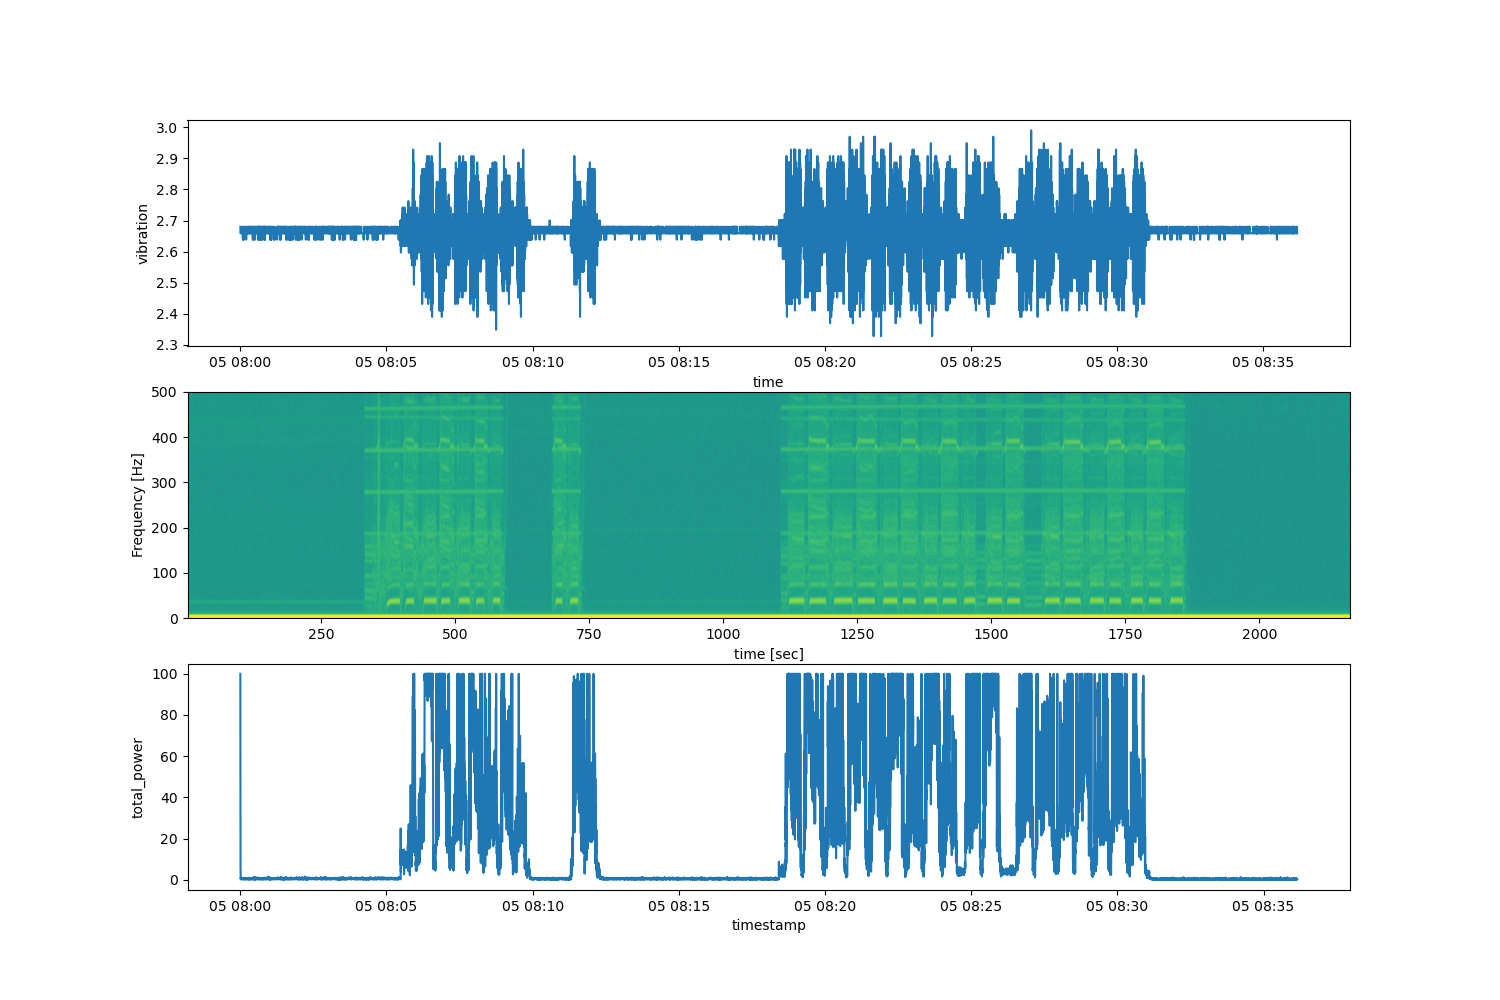

In [10]:
fig, ax = plt.subplots(3,1, figsize=(15,10))
sns.lineplot(df[::100], x='time', y='vibration', ax=ax[0])

ax[1].specgram(df.vibration.values, Fs=1000, noverlap=128, NFFT=256)
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("Frequency [Hz]")

sns.lineplot(power_df, x='timestamp', y='total_power', ax=ax[2])

len(power_df)

In [11]:
df.head()

name                             time  heading  latitude  longitude  speed  \
0  raw        2022-12-05 08:00:00+00:00      NaN       NaN        NaN    NaN   
1  raw 2022-12-05 08:00:00.001000+00:00      NaN       NaN        NaN    NaN   
2  raw 2022-12-05 08:00:00.002000+00:00      NaN       NaN        NaN    NaN   
3  raw 2022-12-05 08:00:00.003000+00:00      NaN       NaN        NaN    NaN   
4  raw 2022-12-05 08:00:00.004000+00:00      NaN       NaN        NaN    NaN   

   temperature  vibration  
0    86.940413   2.679747  
1    86.940413   2.659011  
2    86.940413   2.659011  
3    86.940413   2.679747  
4    86.940413   2.659011

### Remove Power For Training

8268

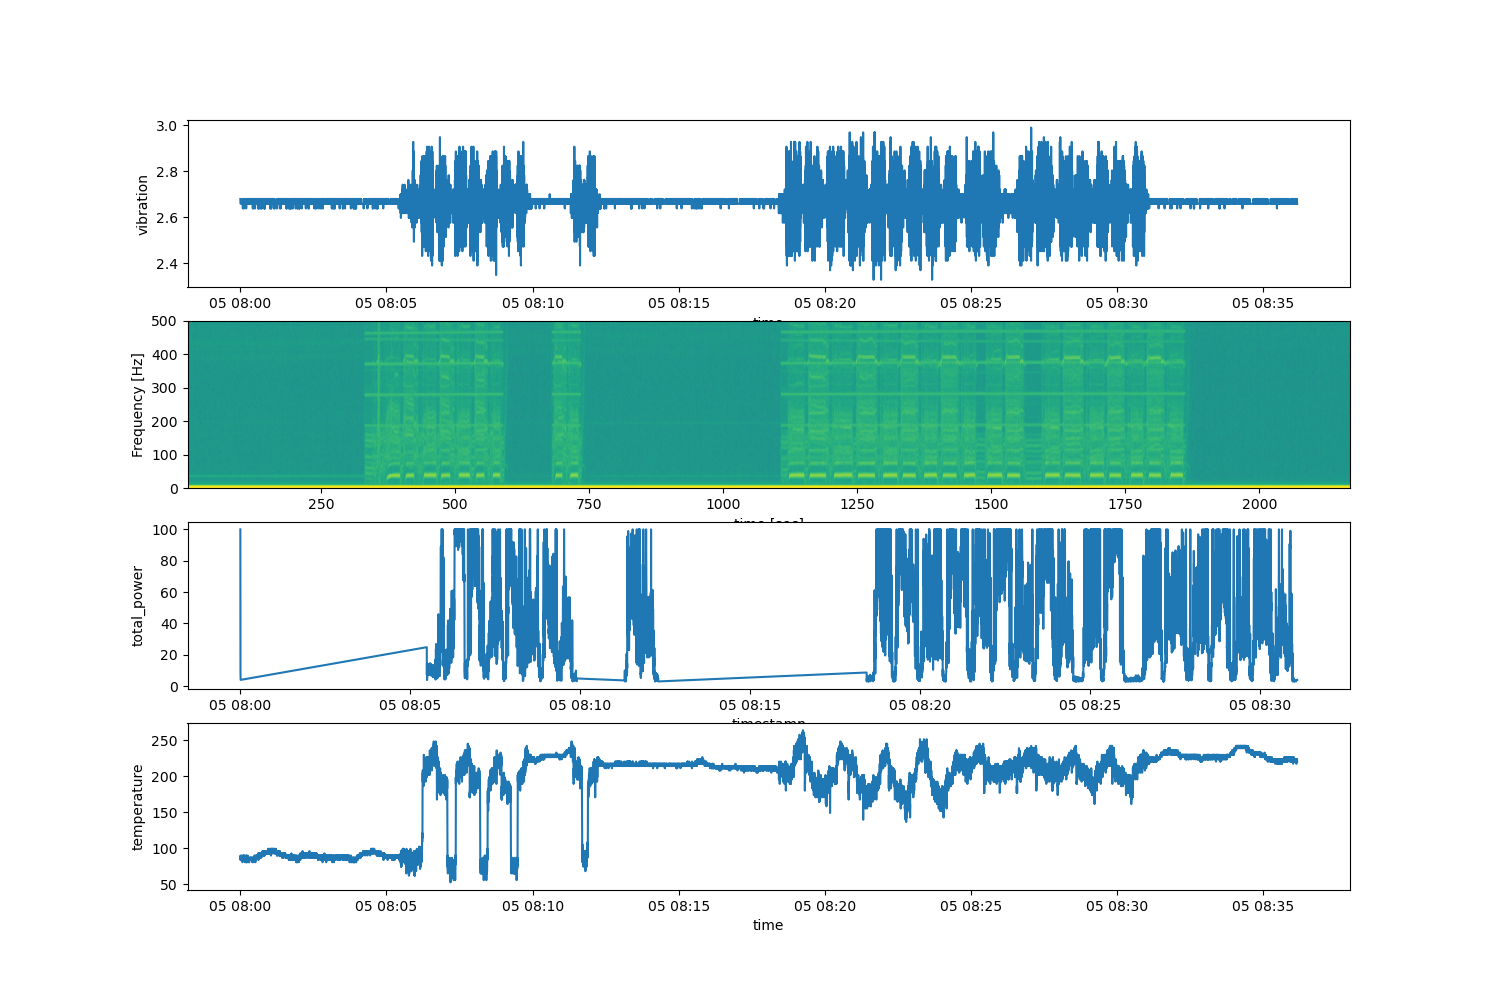

In [12]:
power_df1=power_df[power_df["total_power"]>3.0]
# power_df1=power_df[power_df['total_power']>0.00001]

fig, ax = plt.subplots(4,1, figsize=(15,10))
sns.lineplot(df[::100], x='time', y='vibration', ax=ax[0])

ax[1].specgram(df.vibration.values, Fs=1000, noverlap=128, NFFT=256)
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("Frequency [Hz]")

sns.lineplot(power_df1, x='timestamp', y='total_power', ax=ax[2])
sns.lineplot(df[::100], x='time', y='temperature', ax=ax[3])

power_df=power_df1
len(power_df)

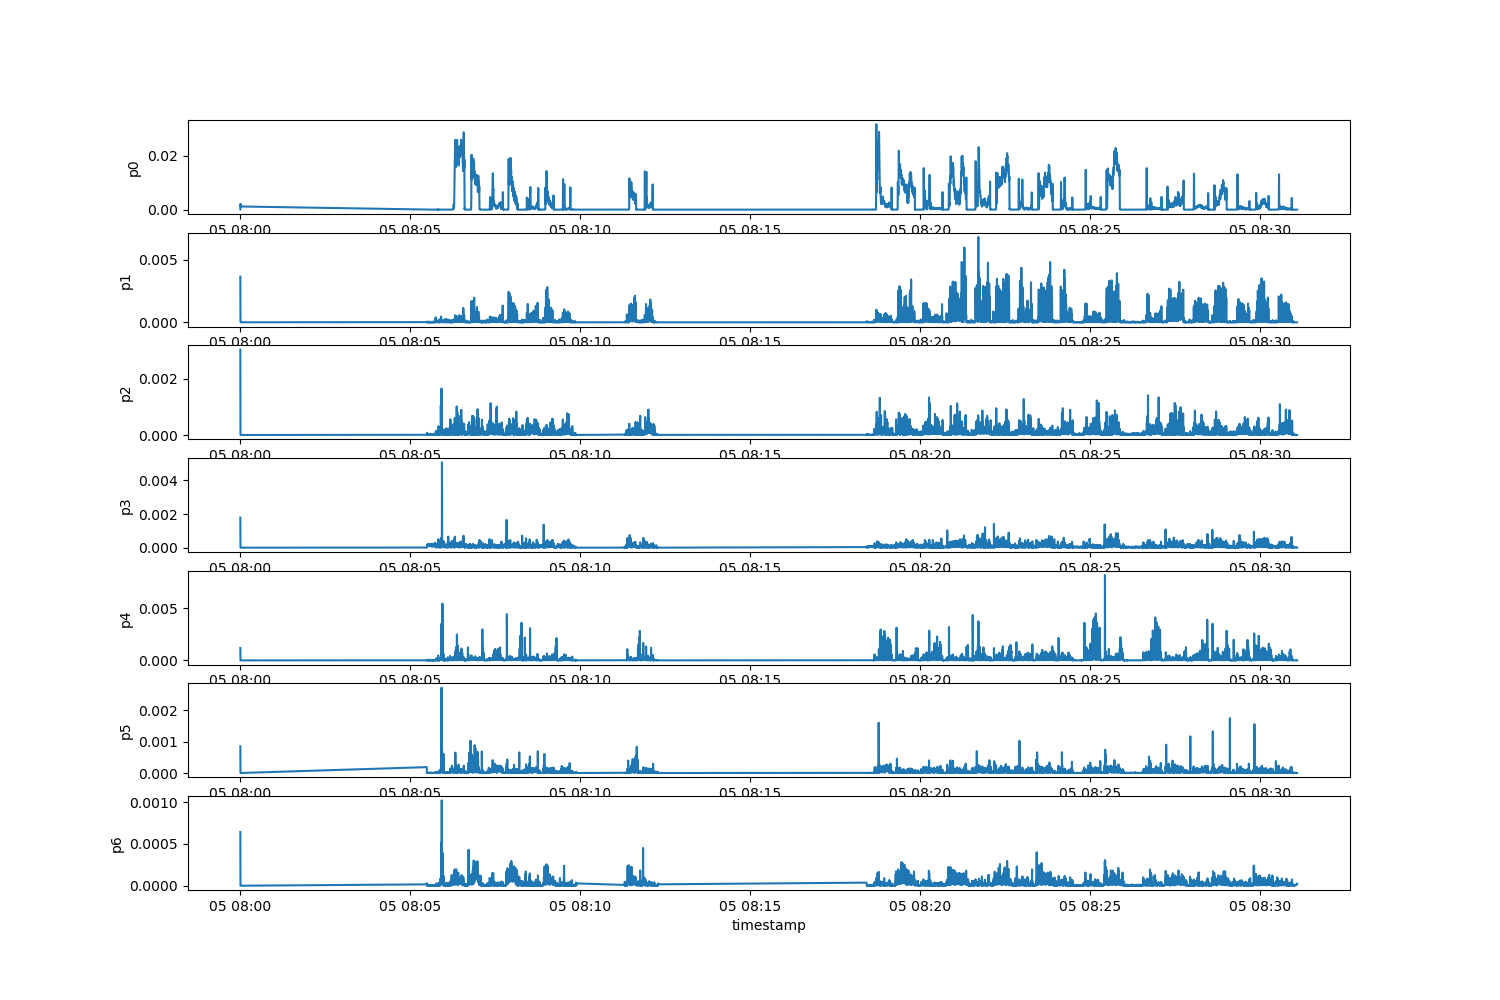

In [13]:
fig, ax = plt.subplots(7,1, figsize=(15,10))
sns.lineplot(power_df, x='timestamp', y='p0', ax=ax[0])
sns.lineplot(power_df, x='timestamp', y='p1', ax=ax[1])
sns.lineplot(power_df, x='timestamp', y='p2', ax=ax[2])
sns.lineplot(power_df, x='timestamp', y='p3', ax=ax[3])
sns.lineplot(power_df, x='timestamp', y='p4', ax=ax[4])
sns.lineplot(power_df, x='timestamp', y='p5', ax=ax[5])
sns.lineplot(power_df, x='timestamp', y='p6', ax=ax[6])

### tSNE Manifold
* Mapping 7 dimensions down to 3

In [14]:
normalized_df = power_df.copy()
# normalized_df = normalized_df.drop(['timestamp'], axis=1)
normalized_df.iloc[:, 2:] = normalized_df.iloc[:, 2:].apply(zscore)

In [15]:
t_sne = TSNE(n_components=3)

normalized_df = power_df.copy()
# normalized_df = normalized_df.drop(['timestamp'], axis=1)
normalized_df.iloc[:, 2:] = normalized_df.iloc[:, 2:].apply(zscore)

# Raw Power Points xForm
powerPoints = t_sne.fit_transform(power_df.iloc[:, 2:].values)
[powerX, powerY, powerZ] = powerPoints.T

# Normalized Power Points xForm
normPoints = t_sne.fit_transform(normalized_df.iloc[:, 2:].values)
[normX, normY, normZ] = normPoints.T

# Normalized and Clipped xForm
clipPoints = t_sne.fit_transform(normalized_df.iloc[:, 2:].clip(lower=-2, upper=2).values)
[clipX, clipY, clipZ] = clipPoints.T

/home/garrettw/anaconda3/envs/rica-analysis/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/garrettw/anaconda3/envs/rica-analysis/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/garrettw/anaconda3/envs/rica-analysis/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/garrettw/anaconda3/envs/rica-analysis/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/garrettw/anaconda3/envs/rica-analysis/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in T

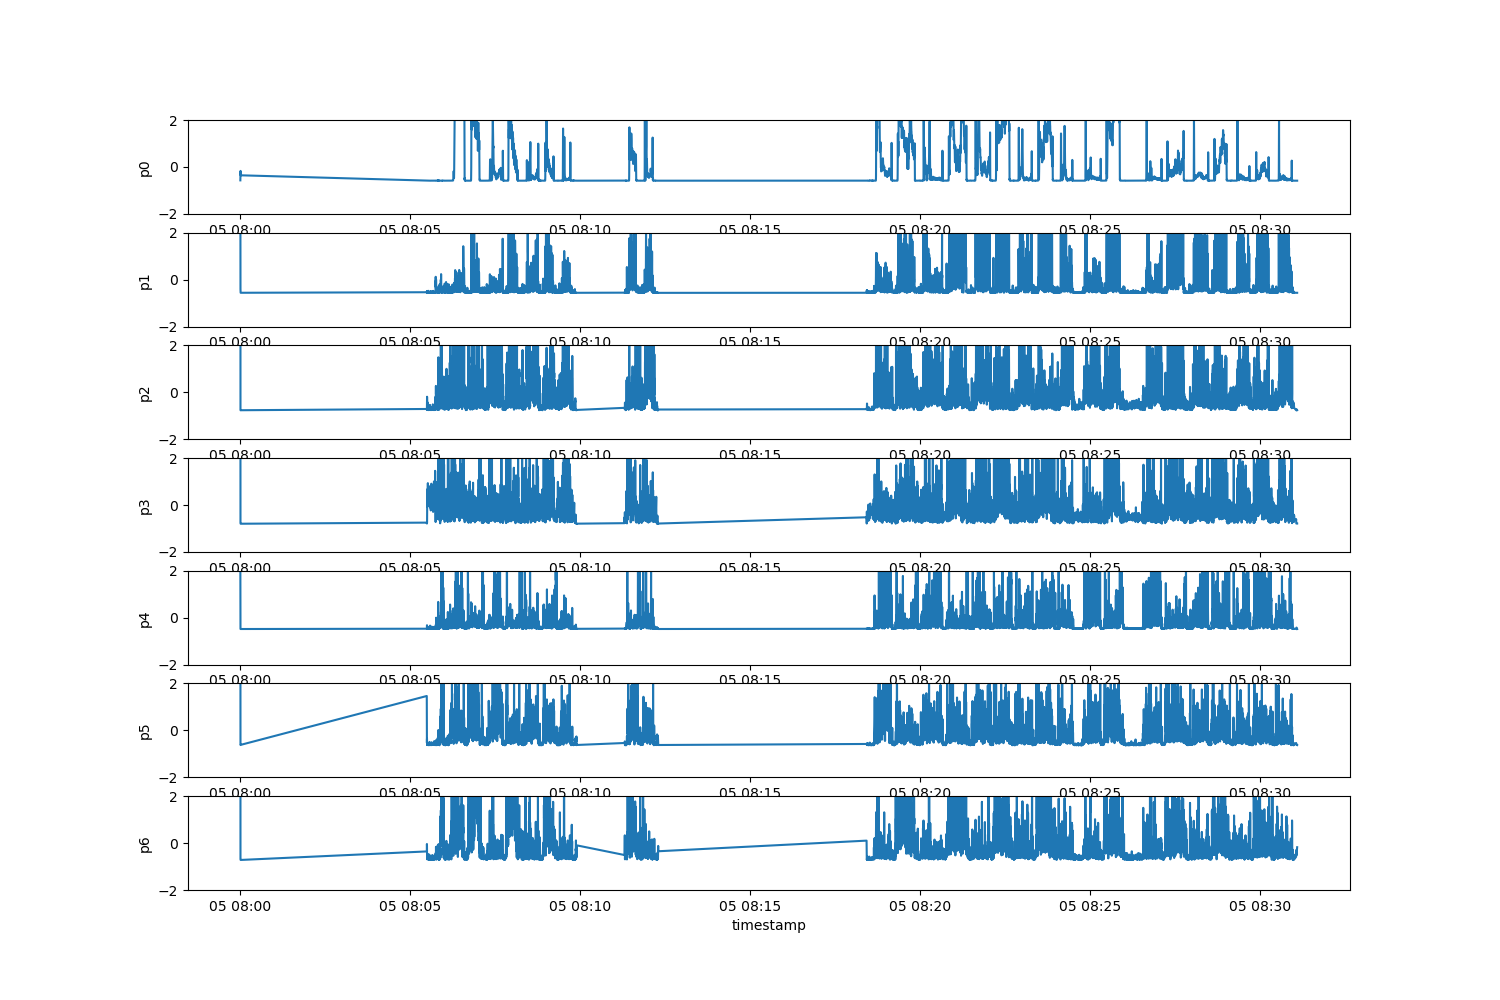

In [16]:
fig, ax = plt.subplots(7,1, figsize=(15,10))
sns.lineplot(normalized_df, x='timestamp', y='p0', ax=ax[0])
sns.lineplot(normalized_df, x='timestamp', y='p1', ax=ax[1])
sns.lineplot(normalized_df, x='timestamp', y='p2', ax=ax[2])
sns.lineplot(normalized_df, x='timestamp', y='p3', ax=ax[3])
sns.lineplot(normalized_df, x='timestamp', y='p4', ax=ax[4])
sns.lineplot(normalized_df, x='timestamp', y='p5', ax=ax[5])
sns.lineplot(normalized_df, x='timestamp', y='p6', ax=ax[6])

for i in range(7):
    ax[i].set_ylim([-2, 2])

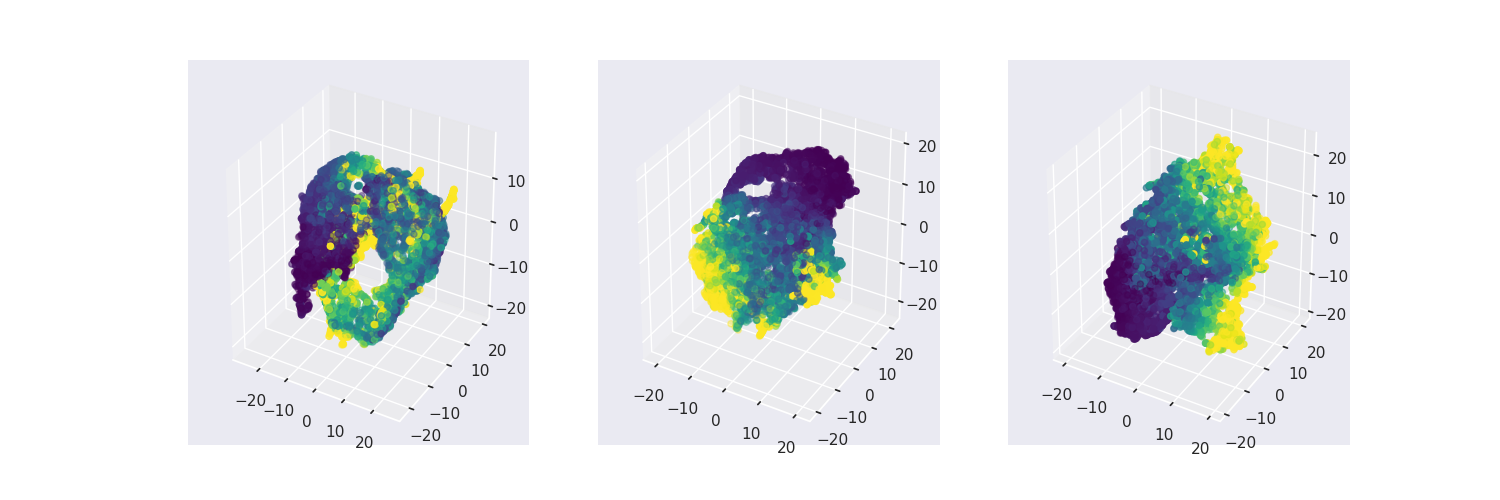

In [17]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(powerX, powerY, powerZ, c=power_df['total_power'], cmap='viridis')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(normX, normY, normZ, c=power_df['total_power'], cmap='viridis')
ax = fig.add_subplot(133, projection='3d')
ax.scatter(clipX, clipY, clipZ, c=power_df['total_power'], cmap='viridis')

# Training

In [18]:
K = 5

In [19]:
training_data = power_df.copy()
training_data.iloc[:, 2:] = training_data.iloc[:, 2:]
X1 = training_data.iloc[:, 2:].values


model = train(training_data, K)
# os.environ['APP_HOME'] = str(RICA_HOME)
# model = load_ExtendedKMeans('model.pkl')

# model.cluster_centers_ = [[-2, -2, -2, -2, -2, -2, -2], [-1, -1, -1, -1, -1, -1, -1], [0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2]]
power_labels = model.predict(X1)

                         timestamp  total_power        p0        p1  \
0 2022-12-05 08:00:00.127000+00:00   100.000000  0.000070  0.003653   
1 2022-12-05 08:00:00.254000+00:00    28.889786  0.000755  0.001030   
2 2022-12-05 08:00:00.381000+00:00     8.302949  0.001932  0.000093   
3 2022-12-05 08:00:00.508000+00:00     7.196575  0.002118  0.000012   
4 2022-12-05 08:00:00.635000+00:00     4.047146  0.001167  0.000003   

             p2        p3            p4        p5            p6  
0  3.047887e-03  0.001790  1.188727e-03  0.000847  6.435617e-04  
1  8.014124e-05  0.000047  3.077300e-05  0.000028  2.220058e-05  
2  3.379538e-06  0.000005  2.234503e-06  0.000003  1.714438e-06  
3  3.382932e-07  0.000001  1.899533e-06  0.000001  4.033190e-07  
4  7.302041e-07  0.000001  7.137937e-07  0.000002  3.109429e-07  


In [20]:
training_data = normalized_df.copy()
training_data.iloc[:, 2:] = training_data.iloc[:, 2:]
X2 = training_data.iloc[:, 2:].values

model = train(training_data, K)
norm_labels = model.predict(X2)

                         timestamp  total_power        p0        p1  \
0 2022-12-05 08:00:00.127000+00:00   100.000000 -0.571295  5.699649   
1 2022-12-05 08:00:00.254000+00:00    28.889786 -0.436633  1.201423   
2 2022-12-05 08:00:00.381000+00:00     8.302949 -0.205272 -0.404308   
3 2022-12-05 08:00:00.508000+00:00     7.196575 -0.168621 -0.543446   
4 2022-12-05 08:00:00.635000+00:00     4.047146 -0.355655 -0.559564   

          p2         p3        p4        p5         p6  
0  21.410845  13.195197  2.472340  8.864179  13.646867  
1  -0.185288  -0.436772 -0.407915 -0.328837  -0.231099  
2  -0.743879  -0.767687 -0.478900 -0.607538  -0.688653  
3  -0.766010  -0.794522 -0.479734 -0.625868  -0.717937  
4  -0.763158  -0.797877 -0.482683 -0.618332  -0.720000  


In [21]:
training_data = normalized_df.copy()
training_data.iloc[:, 2:] = training_data.iloc[:, 2:].clip(-2, 2)
X3 = training_data.iloc[:, 2:].values

print(X3.shape)
model = train(training_data, K)
clip_labels = model.predict(X3)

(8268, 7)
                         timestamp  total_power        p0        p1        p2  \
0 2022-12-05 08:00:00.127000+00:00   100.000000 -0.571295  2.000000  2.000000   
1 2022-12-05 08:00:00.254000+00:00    28.889786 -0.436633  1.201423 -0.185288   
2 2022-12-05 08:00:00.381000+00:00     8.302949 -0.205272 -0.404308 -0.743879   
3 2022-12-05 08:00:00.508000+00:00     7.196575 -0.168621 -0.543446 -0.766010   
4 2022-12-05 08:00:00.635000+00:00     4.047146 -0.355655 -0.559564 -0.763158   

         p3        p4        p5        p6  
0  2.000000  2.000000  2.000000  2.000000  
1 -0.436772 -0.407915 -0.328837 -0.231099  
2 -0.767687 -0.478900 -0.607538 -0.688653  
3 -0.794522 -0.479734 -0.625868 -0.717937  
4 -0.797877 -0.482683 -0.618332 -0.720000  


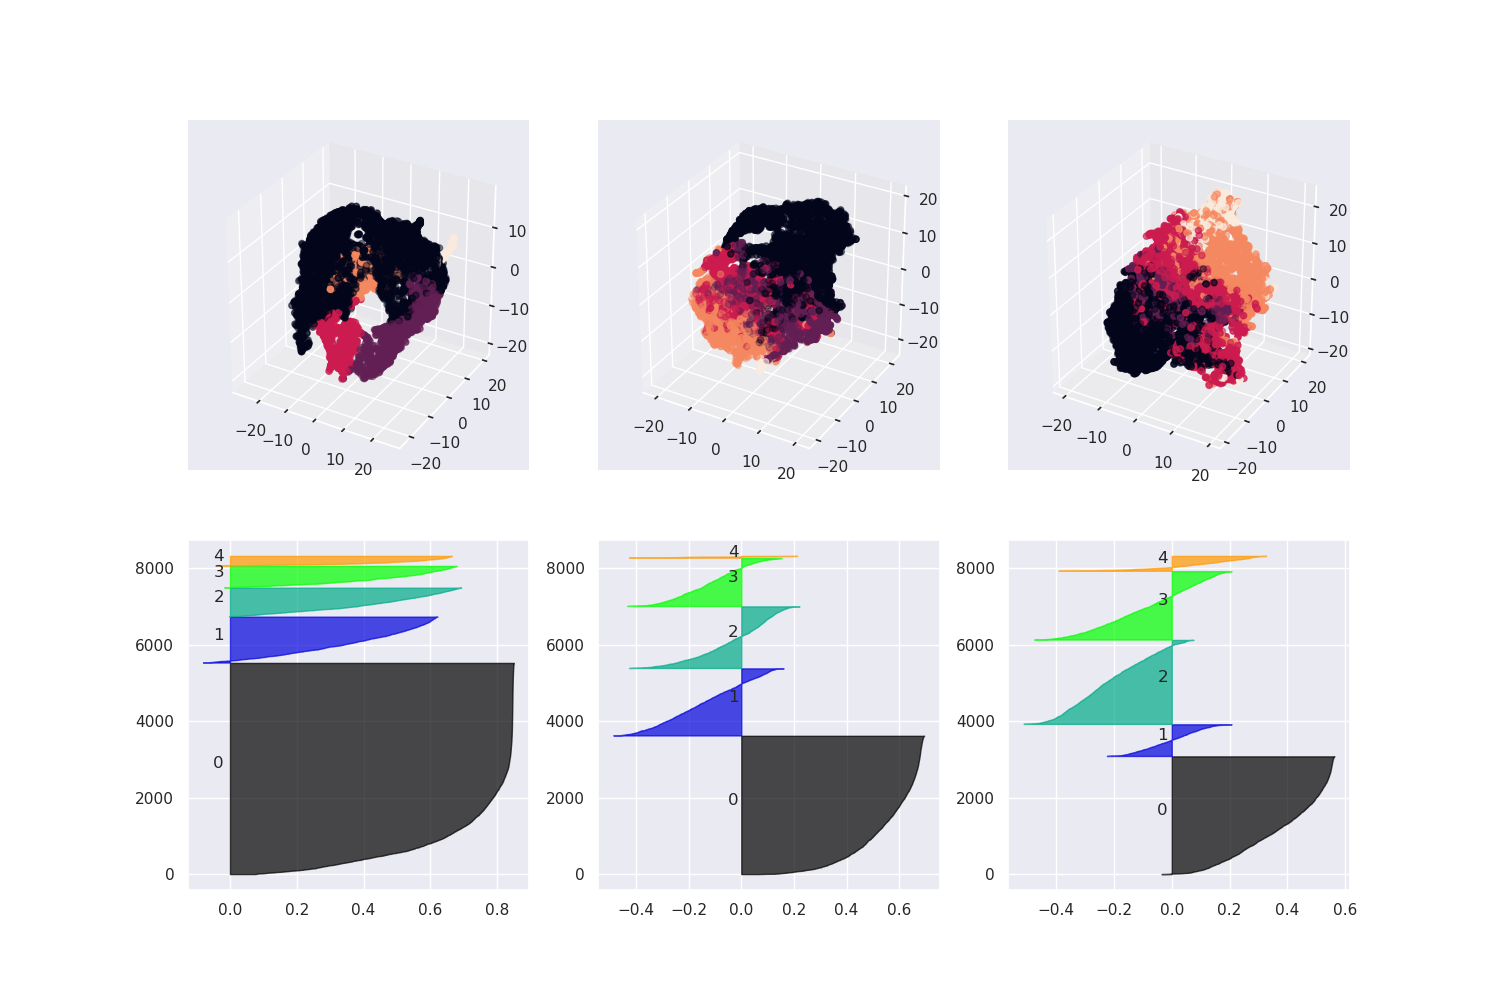

In [22]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(231, projection='3d')
ax.scatter(powerX, powerY, powerZ, c=power_labels)
ax = fig.add_subplot(232, projection='3d')
ax.scatter(normX, normY, normZ, c=norm_labels)
ax = fig.add_subplot(233, projection='3d')
ax.scatter(clipX, clipY, clipZ, c=clip_labels)

ax = fig.add_subplot(234)
_plot_silhouette(X1, power_labels, ax)
ax = fig.add_subplot(235)
_plot_silhouette(X2, norm_labels, ax)
ax = fig.add_subplot(236)
_plot_silhouette(X2, clip_labels, ax)

### Color coded Power plot

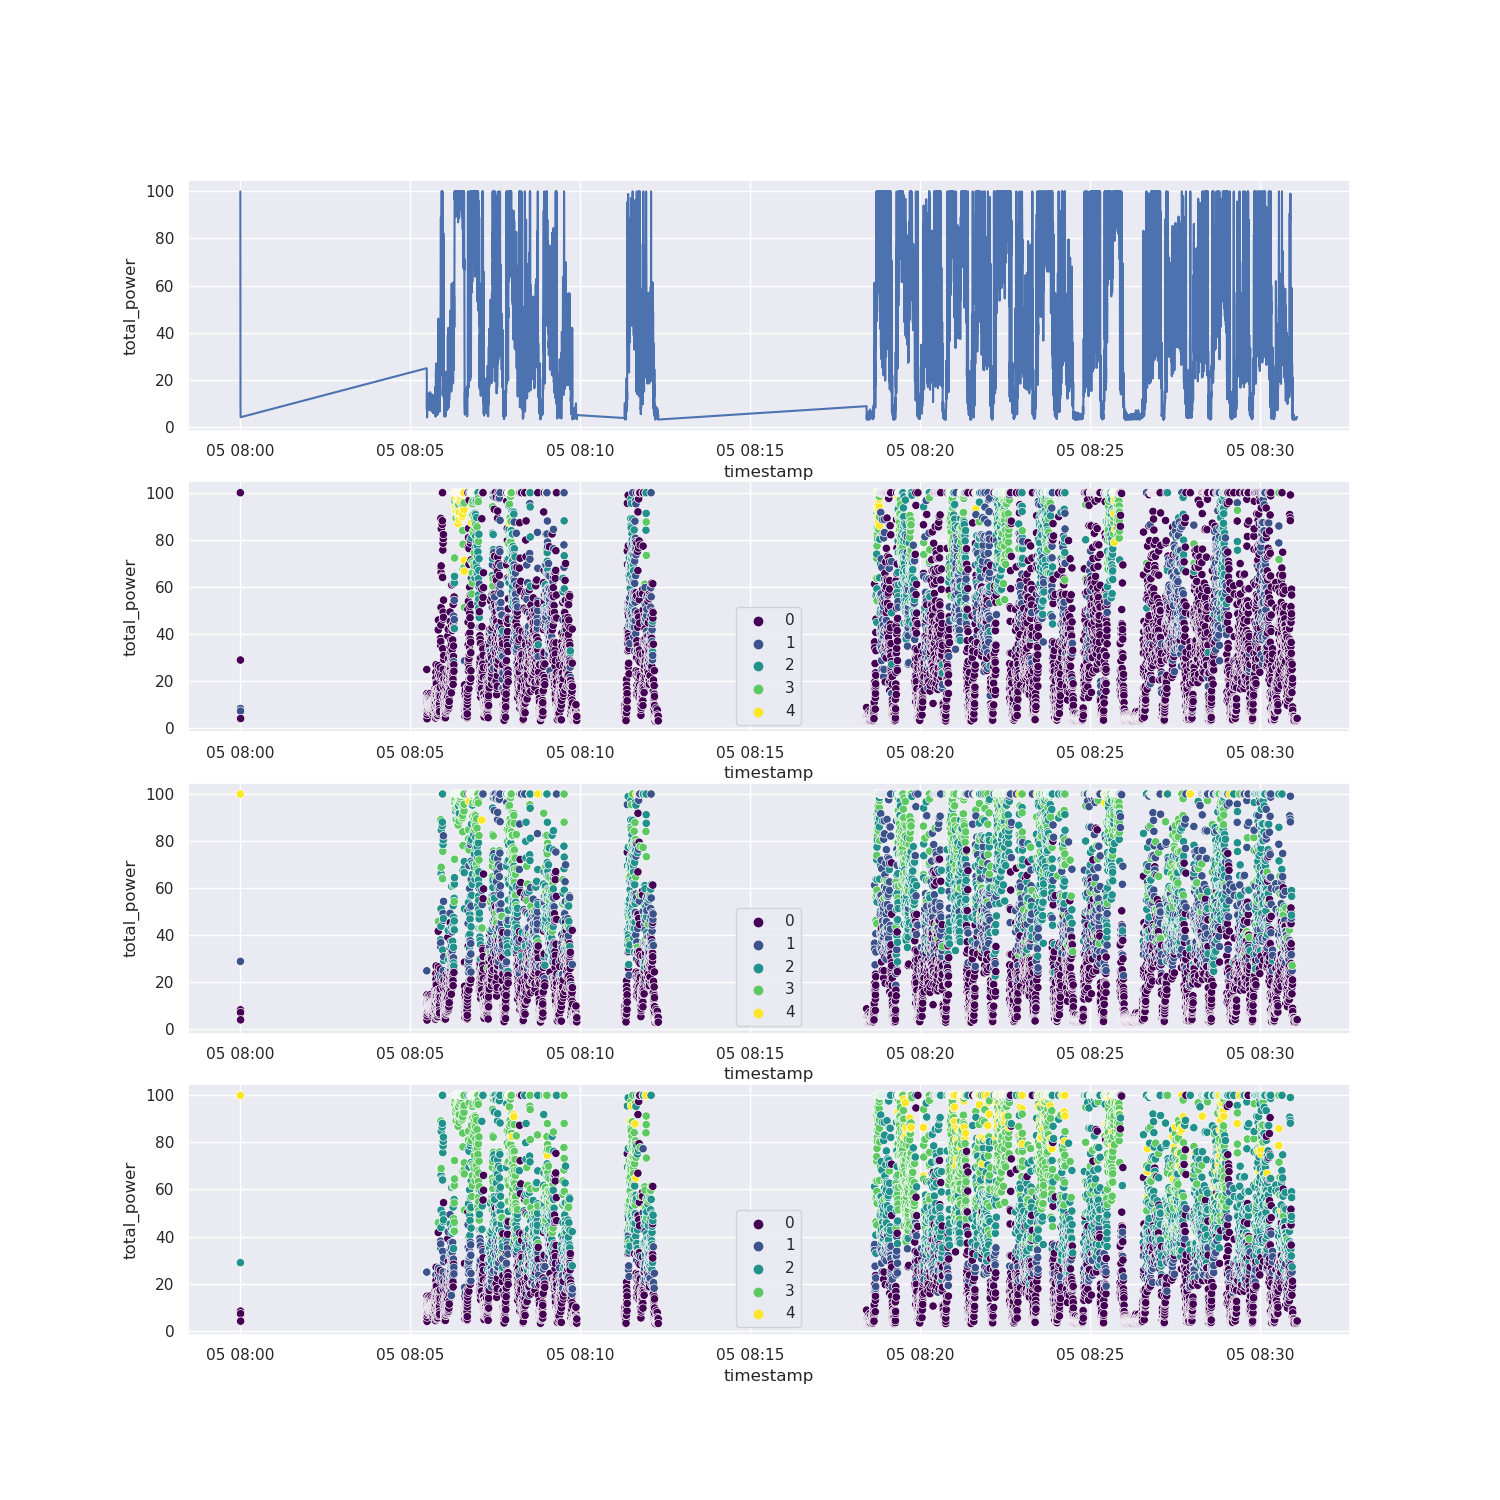

In [23]:
fig, ax = plt.subplots(4, 1, figsize=(15,15))

sns.lineplot(power_df, x='timestamp', y='total_power', ax=ax[0])
sns.scatterplot(power_df, x='timestamp', y='total_power', hue=power_labels, palette='viridis', ax=ax[1])
sns.scatterplot(power_df, x='timestamp', y='total_power', hue=norm_labels, palette='viridis', ax=ax[2])
sns.scatterplot(power_df, x='timestamp', y='total_power', hue=clip_labels, palette='viridis', ax=ax[3])

In [24]:
len(clip_labels)

8268

In [25]:
model.cluster_centers_

array([[-0.49909554, -0.40928396, -0.42763002, -0.24774055, -0.27836918,
        -0.34518109, -0.39016748],
       [-0.38353101, -0.24833964, -0.20289561, -0.10383545, -0.26250997,
         0.07210237, -0.19221052],
       [-0.32838064, -0.14177069, -0.16530002, -0.07669527, -0.18516885,
         0.11457296, -0.16090544],
       [ 0.81903626, -0.09326437,  0.42191133,  0.23975407, -0.06290314,
         0.21310579,  0.38966311],
       [ 1.13096393,  1.6961797 ,  0.86011894,  0.45710705,  1.55028581,
         0.36995774,  0.84337561]])

In [26]:
for i in range(K):
    for j in range(i,K):
        d = np.linalg.norm(model.cluster_centers_[i] - model.cluster_centers_[j])
        print(f"{i} -> {j}: {d:0.2f}")

0 -> 0: 0.00
0 -> 1: 0.57
0 -> 2: 0.69
0 -> 3: 1.94
0 -> 4: 3.82
1 -> 1: 0.00
1 -> 2: 0.16
1 -> 3: 1.54
1 -> 4: 3.46
2 -> 2: 0.00
2 -> 3: 1.45
2 -> 4: 3.31
3 -> 3: 0.00
3 -> 4: 2.52
4 -> 4: 0.00


In [27]:
pickle.dump(model, open(PROJECT_PATH / "model.pkl", "wb"))

In [46]:
means=power_df.iloc[:,2:].mean()
std=power_df.iloc[:,2:].std()
params_dict = params.to_dict()
params_dict.update({"fundFreq":float(fund),"mean":list(means),"std":list(std)})
params_dict

{'fundFreq': 35.15625,
 'minDensity': 91,
 'maxDensity': 96,
 'mean': [0.0029753631921033974,
  0.0003289233646669014,
  0.0001056036170558719,
  0.00010301258759023418,
  0.00019476773132909102,
  5.718643683413714e-05,
  3.254764745361411e-05],
 'std': [0.005085112287141376,
  0.0005833187629301302,
  0.00013742855100095706,
  0.0001278506616506276,
  0.0004020561551886474,
  8.915648055860877e-05,
  4.4775915280887056e-05],
 'projectID': 'mchenry',
 'roller': 'intermediate',
 'modelName': 'model.pkl',
 'tempC': 80,
 'tempM': 150}

In [47]:
import yaml
with open(PROJECT_PATH / "calib.yml", "w") as fid:
        yaml.dump(params_dict, fid, default_flow_style=False)

In [30]:
# def read_yml(path_to_calib_yml_file):
    # with open(path_to_calib_yml_file, "r") as fid:
    #     d = yaml.safe_load(fid)
    # return d

In [31]:
power_df

timestamp  total_power            p0        p1  \
0     2022-12-05 08:00:00.127000+00:00   100.000000  7.044215e-05  0.003653   
1     2022-12-05 08:00:00.254000+00:00    28.889786  7.551713e-04  0.001030   
2     2022-12-05 08:00:00.381000+00:00     8.302949  1.931597e-03  0.000093   
3     2022-12-05 08:00:00.508000+00:00     7.196575  2.117957e-03  0.000012   
4     2022-12-05 08:00:00.635000+00:00     4.047146  1.166928e-03  0.000003   
...                                ...          ...           ...       ...   
14672 2022-12-05 08:31:03.471000+00:00     3.130400  9.595766e-07  0.000002   
14673 2022-12-05 08:31:03.598000+00:00     3.902660  9.058100e-07  0.000002   
14675 2022-12-05 08:31:03.852000+00:00     3.564271  2.418739e-07  0.000001   
14678 2022-12-05 08:31:04.233000+00:00     4.061724  2.099071e-07  0.000002   
14687 2022-12-05 08:31:05.376000+00:00     4.101621  6.935962e-07  0.000002   

                 p2        p3            p4        p5            p6  
0      3.047887e-03  0.001790  1.188727e-03  0.000847  6.435617e-04  
1      8.014124e-05  0.000047  3.077300e-05  0.000028  2.220058e-05  
2      3.379538e-06  0.000005  2.234503e-06  0.000003  1.714438e-06  
3      3.382932e-07  0.000001  1.899533e-06  0.000001  4.033190e-07  
4      7.302041e-07  0.000001  7.137937e-07  0.000002  3.109429e-07  
...             ...       ...           ...       ...           ...  
14672  1.701329e-06  0.000023  4.949588e-06  0.000006  6.150206e-06  
14673  1.899165e-06  0.000025  3.301859e-06  0.000009  8.618464e-06  
14675  3.731213e-07  0.000002  3.094262e-06  0.000002  1.935261e-05  
14678  6.838161e-06  0.000002  2.550373e-05  0.000003  9.275065e-06  
14687  1.180812e-06  0.000002  5.935053e-07  0.000001  2.461709e-05  

[8268 rows x 9 columns]

In [32]:
norm_1 = power_df.iloc[:, 1:] - means
norm_1 = norm_1 / std
norm_1

p0        p1         p2         p3        p4        p5  \
0     -0.571260  5.699304  21.409550  13.194399  2.472191  8.863643   
1     -0.436606  1.201350  -0.185277  -0.436745 -0.407890 -0.328817   
2     -0.205259 -0.404283  -0.743834  -0.767640 -0.478871 -0.607501   
3     -0.168611 -0.543413  -0.765964  -0.794474 -0.479705 -0.625830   
4     -0.355633 -0.559530  -0.763112  -0.797829 -0.482654 -0.618294   
...         ...       ...        ...        ...       ...       ...   
14672 -0.584924 -0.560936  -0.756046  -0.627457 -0.472118 -0.578313   
14673 -0.584934 -0.560575  -0.754606  -0.609176 -0.476217 -0.539066   
14675 -0.585065 -0.561721  -0.765711  -0.788451 -0.476733 -0.615287   
14678 -0.585071 -0.559834  -0.718668  -0.788667 -0.420996 -0.606031   
14687 -0.584976 -0.560453  -0.759833  -0.789923 -0.482953 -0.625306   

              p6  total_power  
0      13.646042          NaN  
1      -0.231086          NaN  
2      -0.688611          NaN  
3      -0.717893          NaN  
4      -0.719956          NaN  
...          ...          ...  
14672  -0.589546          NaN  
14673  -0.534421          NaN  
14675  -0.294690          NaN  
14678  -0.519757          NaN  
14687  -0.177116          NaN  

[8268 rows x 8 columns]

In [33]:
normalized_df

timestamp  total_power        p0        p1  \
0     2022-12-05 08:00:00.127000+00:00   100.000000 -0.571295  5.699649   
1     2022-12-05 08:00:00.254000+00:00    28.889786 -0.436633  1.201423   
2     2022-12-05 08:00:00.381000+00:00     8.302949 -0.205272 -0.404308   
3     2022-12-05 08:00:00.508000+00:00     7.196575 -0.168621 -0.543446   
4     2022-12-05 08:00:00.635000+00:00     4.047146 -0.355655 -0.559564   
...                                ...          ...       ...       ...   
14672 2022-12-05 08:31:03.471000+00:00     3.130400 -0.584959 -0.560970   
14673 2022-12-05 08:31:03.598000+00:00     3.902660 -0.584970 -0.560609   
14675 2022-12-05 08:31:03.852000+00:00     3.564271 -0.585100 -0.561754   
14678 2022-12-05 08:31:04.233000+00:00     4.061724 -0.585107 -0.559868   
14687 2022-12-05 08:31:05.376000+00:00     4.101621 -0.585012 -0.560487   

              p2         p3        p4        p5         p6  
0      21.410845  13.195197  2.472340  8.864179  13.646867  
1      -0.185288  -0.436772 -0.407915 -0.328837  -0.231099  
2      -0.743879  -0.767687 -0.478900 -0.607538  -0.688653  
3      -0.766010  -0.794522 -0.479734 -0.625868  -0.717937  
4      -0.763158  -0.797877 -0.482683 -0.618332  -0.720000  
...          ...        ...       ...       ...        ...  
14672  -0.756092  -0.627495 -0.472147 -0.578348  -0.589581  
14673  -0.754652  -0.609213 -0.476246 -0.539099  -0.534453  
14675  -0.765757  -0.788499 -0.476762 -0.615324  -0.294708  
14678  -0.718711  -0.788715 -0.421021 -0.606067  -0.519788  
14687  -0.759879  -0.789970 -0.482982 -0.625343  -0.177127  

[8268 rows x 9 columns]

In [34]:
print(params_dict)
params_dict['minDensity'] = 88
params_dict['maxDensity'] = 92

# Create filter & Power objects
oFilter = create_filter_bank(params_dict.copy())
(oPower, _) = create_power_object(params_dict.copy())

# Get Raw Power
power_list_post = compute_all_power(oFilter, oPower, vib_list)
power_df_post = power_to_df(power_list_post)

{'fundFreq': 35.15625, 'minDensity': 91, 'maxDensity': 96, 'mean': [0.0029753631921033974, 0.0003289233646669014, 0.0001056036170558719, 0.00010301258759023418, 0.00019476773132909102, 5.718643683413714e-05, 3.254764745361411e-05], 'std': [0.005085112287141376, 0.0005833187629301302, 0.00013742855100095706, 0.0001278506616506276, 0.0004020561551886474, 8.915648055860877e-05, 4.4775915280887056e-05], 'projectID': 'mchenry', 'roller': 'intermediate', 'modelName': 'model.pkl', 'tempC': 80, 'tempM': 150}


In [35]:
from rica.use_cases.density import create_densityModule_object, model_predict

In [36]:
oDensity, _ = create_densityModule_object(params_dict)

In [37]:
d_list = []
for p in power_list_post:
    d = model_predict(p, oDensity, model)
    d_list.append(d.to_dict()['density'])
    # d_list.append(d)
d_list=np.array(d_list)

In [38]:
d_list[:10]

array([91.93, 90.  , 88.07, 88.07, 88.07, 88.07, 88.07, 88.07, 88.07,
       88.07])

In [39]:
power_list_post[:10]

[Power(timestamp=Timestamp('2022-12-05 08:00:00.127000+0000', tz='UTC'), total_power=0.00020086164046410226, p0=-0.5712599595596932, p1=2.0, p2=2.0, p3=2.0, p4=2.0, p5=2.0, p6=2.0),
 Power(timestamp=Timestamp('2022-12-05 08:00:00.254000+0000', tz='UTC'), total_power=1.1383813139824387e-05, p0=-0.43660627573591837, p1=1.2013501238815092, p2=-0.18527718605636048, p3=-0.43674537104051087, p4=-0.40789012454098345, p5=-0.3288173619758114, p6=-0.2310855084779235),
 Power(timestamp=Timestamp('2022-12-05 08:00:00.381000+0000', tz='UTC'), total_power=3.288940342480644e-06, p0=-0.2052592489278217, p1=-0.4042830749749048, p2=-0.7438343688310493, p3=-0.7676402922400595, p4=-0.4788714868395065, p5=-0.6075010510875883, p6=-0.6886114932838742),
 Power(timestamp=Timestamp('2022-12-05 08:00:00.508000+0000', tz='UTC'), total_power=2.853907215960807e-06, p0=-0.16861099511809788, p1=-0.5434132908089067, p2=-0.7659640088513213, p3=-0.794473771696005, p4=-0.47970462688000226, p5=-0.6258301641764642, p6=-0.7

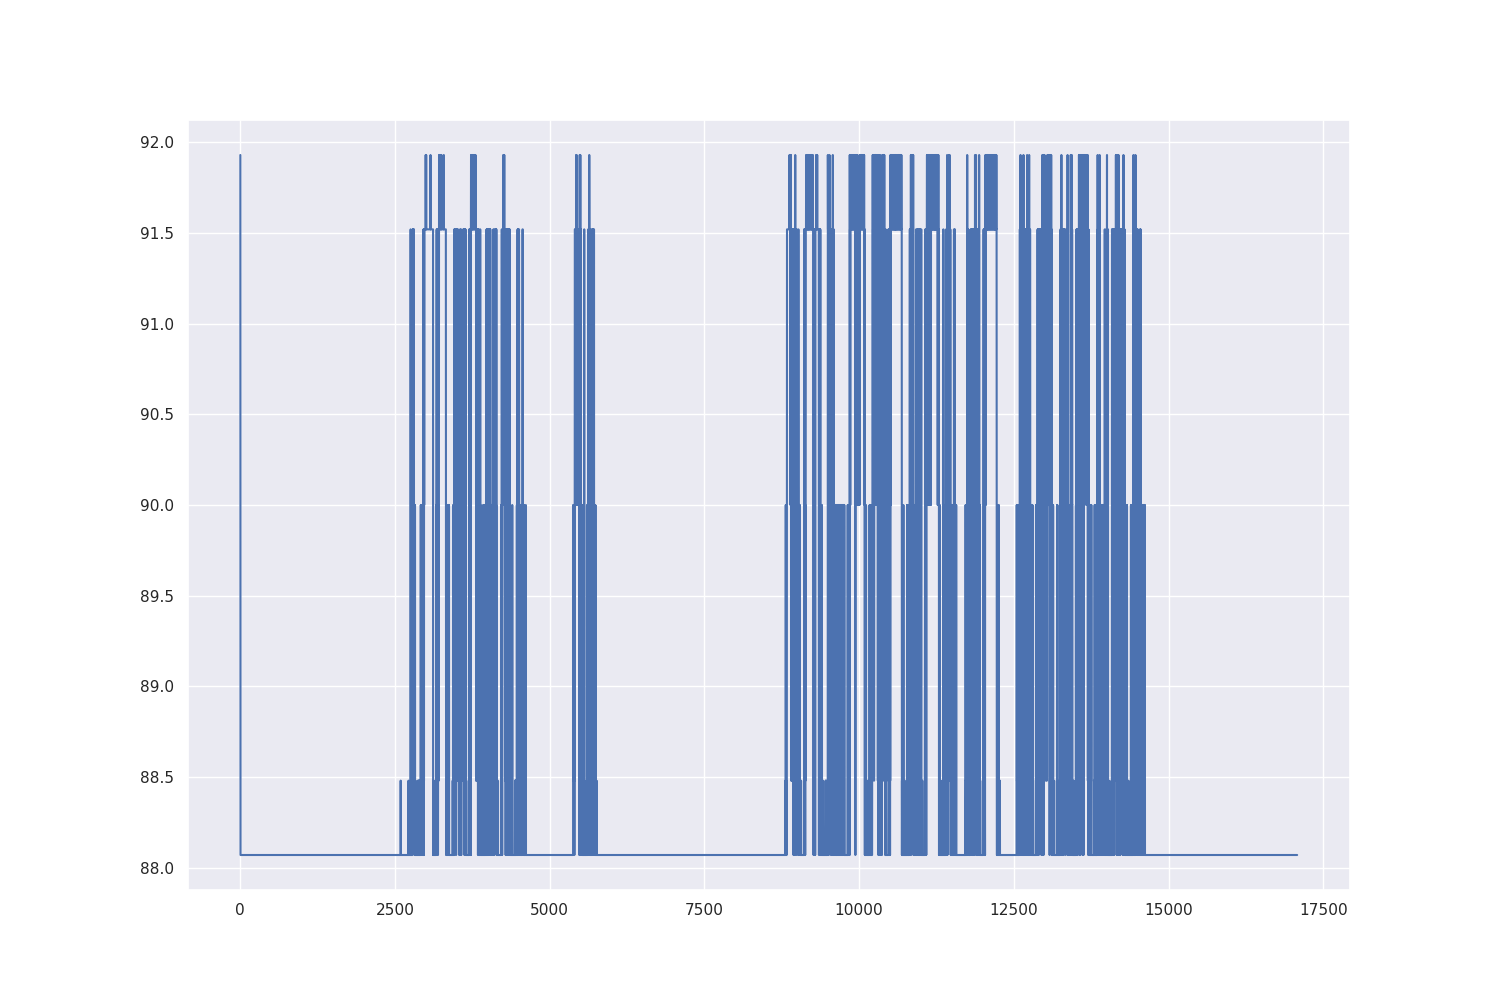

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.lineplot(d_list, ax=ax)

In [41]:
d_list[0]

91.93

In [42]:
df_out = pd.DataFrame([])
for i in range(len(d_list)):
    df_out = df_out.append({'timestamp': power_list_post[i].timestamp, 'density_post': d_list[i]}, ignore_index=True)

In [43]:
df_out.head()

timestamp  density_post
0 2022-12-05 08:00:00.127000+00:00         91.93
1 2022-12-05 08:00:00.254000+00:00         90.00
2 2022-12-05 08:00:00.381000+00:00         88.07
3 2022-12-05 08:00:00.508000+00:00         88.07
4 2022-12-05 08:00:00.635000+00:00         88.07

In [44]:
df_out.to_csv(RICA_HOME / 'projects/shawnee/density_post.csv')